In [1]:
import torch
import json
import h5py
import random
import numpy as np
from matplotlib.pyplot import imshow
from PIL import Image, ImageDraw

In [2]:
# load the following to files from DETECTED_SGG_DIR
custom_prediction = json.load(open('../../checkpoints/custom_images/custom_prediction.json'))
custom_data_info = json.load(open('../../checkpoints/custom_images/custom_data_info.json'))

In [3]:
def draw_single_box(pic, box, color='red', draw_info=None):
    draw = ImageDraw.Draw(pic)
    x1,y1,x2,y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    draw.rectangle(((x1, y1), (x2, y2)), outline=color)
    if draw_info:
        draw.rectangle(((x1, y1), (x1+50, y1+10)), fill=color)
        info = draw_info
        draw.text((x1, y1), info)
        
def print_list(name, input_list, scores=None):
    for i, item in enumerate(input_list):
        if scores == None:
            print(name + ' ' + str(i) + ': ' + str(item))
        else:
            print(name + ' ' + str(i) + ': ' + str(item) + '; score: ' + str(scores[i]))
    
def draw_image(img_path, boxes, box_labels, rel_labels, box_scores=None, rel_scores=None):
    size = get_size(Image.open(img_path).size)
    pic = Image.open(img_path).resize(size)
    num_obj = len(boxes)
    for i in range(num_obj):
        info = str(i) + '_' + box_labels[i]
        draw_single_box(pic, boxes[i], draw_info=info)
    display(pic)
    print('*' * 50)
    print_list('box_labels', box_labels, box_scores)
    print('*' * 50)
    print_list('rel_labels', rel_labels, rel_scores)
    
    return None

def get_size(image_size):
    min_size = 600
    max_size = 1000
    w, h = image_size
    size = min_size
    if max_size is not None:
        min_original_size = float(min((w, h)))
        max_original_size = float(max((w, h)))
        if max_original_size / min_original_size * size > max_size:
            size = int(round(max_size * min_original_size / max_original_size))
    if (w <= h and w == size) or (h <= w and h == size):
        return (w, h)
    if w < h:
        ow = size
        oh = int(size * h / w)
    else:
        oh = size
        ow = int(size * w / h)
    return (ow, oh)

In [36]:
# parameters
image_idx = 1
box_topk = 10 # select top k bounding boxes
rel_topk = 40 # select top k relationships
ind_to_classes = custom_data_info['ind_to_classes']
ind_to_predicates = custom_data_info['ind_to_predicates']

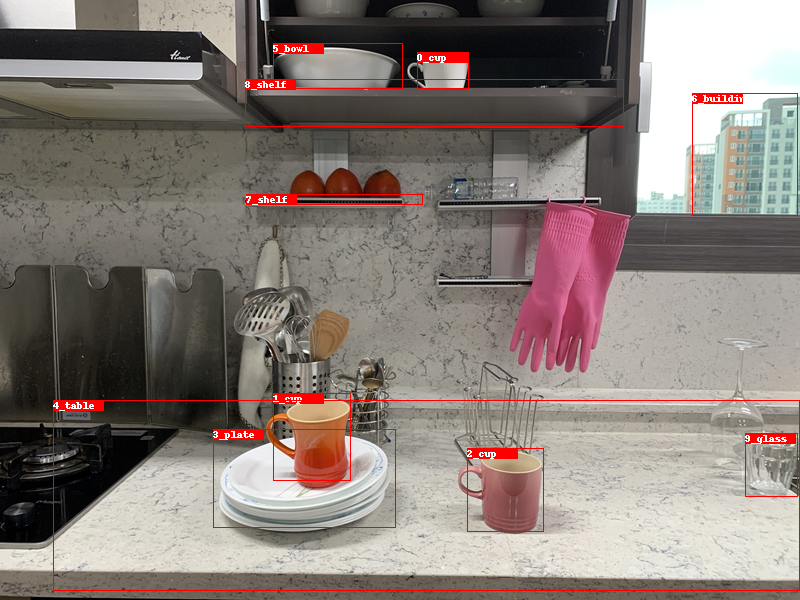

**************************************************
box_labels 0: cup; score: 0.7830367684364319
box_labels 1: cup; score: 0.6915701627731323
box_labels 2: cup; score: 0.6756981015205383
box_labels 3: plate; score: 0.649378776550293
box_labels 4: table; score: 0.6424957513809204
box_labels 5: bowl; score: 0.42251962423324585
box_labels 6: building; score: 0.3790181577205658
box_labels 7: shelf; score: 0.31562891602516174
box_labels 8: shelf; score: 0.28308695554733276
box_labels 9: glass; score: 0.26473936438560486
**************************************************
rel_labels 0: 5_bowl => on => 8_shelf; score: 0.7822498679161072
rel_labels 1: 0_cup => on => 8_shelf; score: 0.656710684299469
rel_labels 2: 2_cup => on => 4_table; score: 0.3906431198120117
rel_labels 3: 9_glass => on => 4_table; score: 0.3898385167121887
rel_labels 4: 1_cup => on => 4_table; score: 0.2586595118045807
rel_labels 5: 3_plate => on => 4_table; score: 0.2546839416027069
rel_labels 6: 1_cup => on => 3_plate; sco

In [37]:
image_path = custom_data_info['idx_to_files'][image_idx]
boxes = custom_prediction[str(image_idx)]['bbox'][:box_topk]
box_labels = custom_prediction[str(image_idx)]['bbox_labels'][:box_topk]
box_scores = custom_prediction[str(image_idx)]['bbox_scores'][:box_topk]
all_rel_labels = custom_prediction[str(image_idx)]['rel_labels']
all_rel_scores = custom_prediction[str(image_idx)]['rel_scores']
all_rel_pairs = custom_prediction[str(image_idx)]['rel_pairs']

for i in range(len(box_labels)):
    box_labels[i] = ind_to_classes[box_labels[i]]

rel_labels = []
rel_scores = []
for i in range(len(all_rel_pairs)):
    if all_rel_pairs[i][0] < box_topk and all_rel_pairs[i][1] < box_topk:
        rel_scores.append(all_rel_scores[i])
        label = str(all_rel_pairs[i][0]) + '_' + box_labels[all_rel_pairs[i][0]] + ' => ' + ind_to_predicates[all_rel_labels[i]] + ' => ' + str(all_rel_pairs[i][1]) + '_' + box_labels[all_rel_pairs[i][1]]
        rel_labels.append(label)

rel_labels = rel_labels[:rel_topk]
rel_scores = rel_scores[:rel_topk]

draw_image(image_path, boxes, box_labels, rel_labels, box_scores=box_scores, rel_scores=rel_scores)

In [38]:
# scene graph pruning
def prune_sg(target, rel_labels, rel_scores):
    # target = "cup"
    pruned_labels = []
    pruned_scores = []
    for i, label in enumerate(rel_labels):
        if target in label:
            pruned_labels.append(label)
            pruned_scores.append(rel_scores[i])
    return pruned_labels, pruned_scores

In [39]:
def find_target(rel):
    o1, _, _ = rel.split(' => ')
    return o1

def find_relation(rel):
    _, _, o2 = rel.split(' => ')
    return o2

# check if there are multiple targets detected
# labels = box_labels.copy()
# labels.remove('cup')
# if target not in labels:
#     print('there are no duplicate target objs!')
# num_target = box_labels.count(target)

# filter and retrieve {num_target} objects from graph
# return: (list) list of {num_target} relations
def filter_rels(pruned_labels, pruned_scores, num_target):
    target_objs = []
    relation_objs = []
    idxs = []
    for i, label in enumerate(pruned_labels):
    #"rel_labels 1: 0_cup => on => 8_shelf"
        if len(target_objs) == num_target:
            break
        target_obj = find_target(label)
        relation_obj = find_relation(label)
        if not target_objs:
            target_objs.append(target_obj)
            relation_objs.append(relation_obj)
            idxs.append(i)
            continue
        if pruned_scores[i-1] / pruned_scores[i] > 100:
            break
        if (target_obj in target_objs) or (relation_obj in relation_objs):
            continue
        else:  
            target_objs.append(target_obj)
            relation_objs.append(relation_obj)
            idxs.append(i)
    pruned_labels = np.array(pruned_labels)
    return pruned_labels[idxs]

In [40]:
# return strings of (obj, relation, obj)
def breakdown(rel):
    o1, r, o2 = rel.split(' => ')
    return [o1[2:], r, o2[2:]]

In [41]:
# print positional info of target objects
# rels: (list) list of relations (relation -> obj)
def ask_back(rels):
    print(f"Do you mean...")
    for i, rel in enumerate(rels):
        o1, r, o2 = breakdown(rel)
        print(f"{i}: {o1} {r} {o2}?")
    # user input index 
    usr_input = int(input("Choose an index: "))
    result = rels[usr_input]
    print(result)
    return result

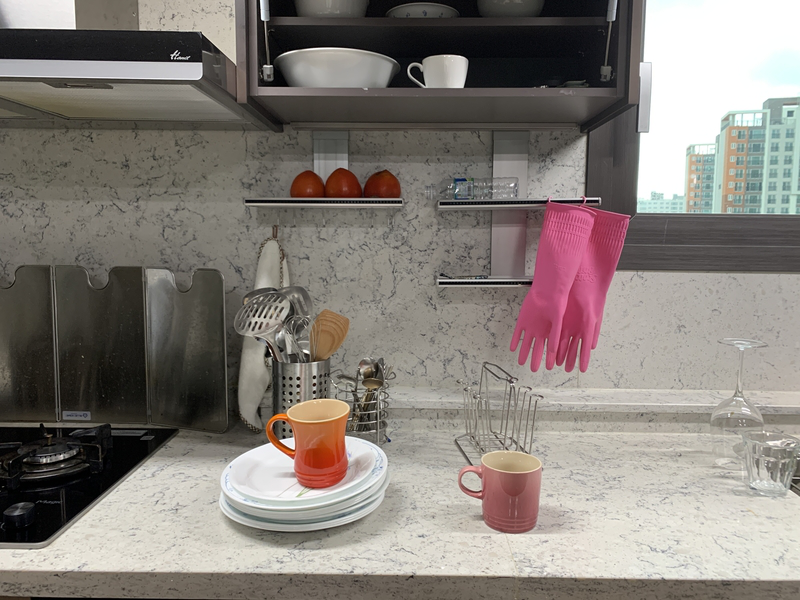

Target object: cup
Do you mean...
0: cup on shelf?
1: cup on table?
2: cup on plate?
Choose an index: 2
1_cup => on => 3_plate


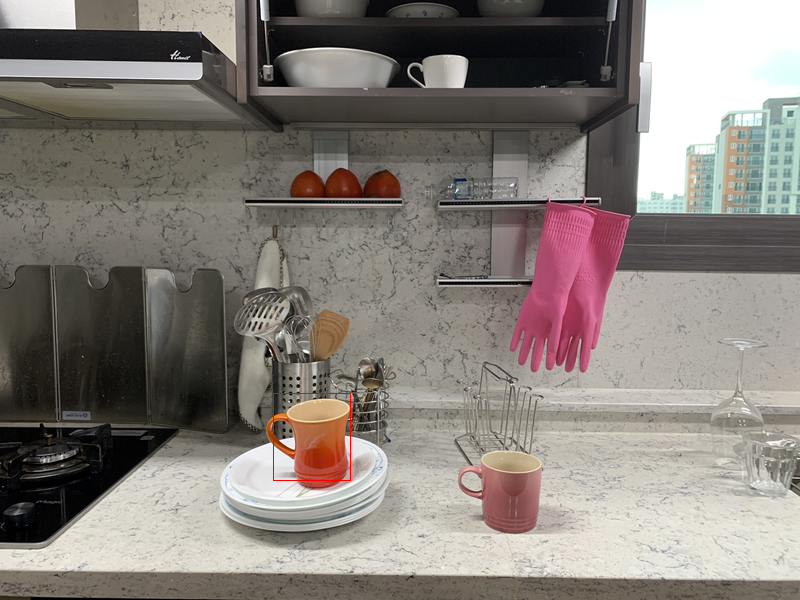

In [42]:
# display image
size = get_size(Image.open(image_path).size)
pic = Image.open(image_path).resize(size)
display(pic)

# ask for target object
target = input("Target object: ")
# prune graph
pruned_labels, pruned_scores = prune_sg(target, rel_labels, rel_scores)
# filter relations
num_target = box_labels.count(target)
filtered_rels = filter_rels(pruned_labels, pruned_scores, num_target)
result = ask_back(filtered_rels)
obj = result.split(" => ")[0]
draw_single_box(pic, boxes[int(obj[0])])
display(pic)